# Application of GSP Methods on New York Data Set

# 1. Download the data set

Before being able to run our code, one must download the New York taxi trip data set. Our results are based on the 2018 data set, which can be found here: https://data.cityofnewyork.us/Transportation/2018-Yellow-Taxi-Trip-Data/t29m-gskq/about_data. Click on "Actions" and "Query data". Your screen should look like this now:

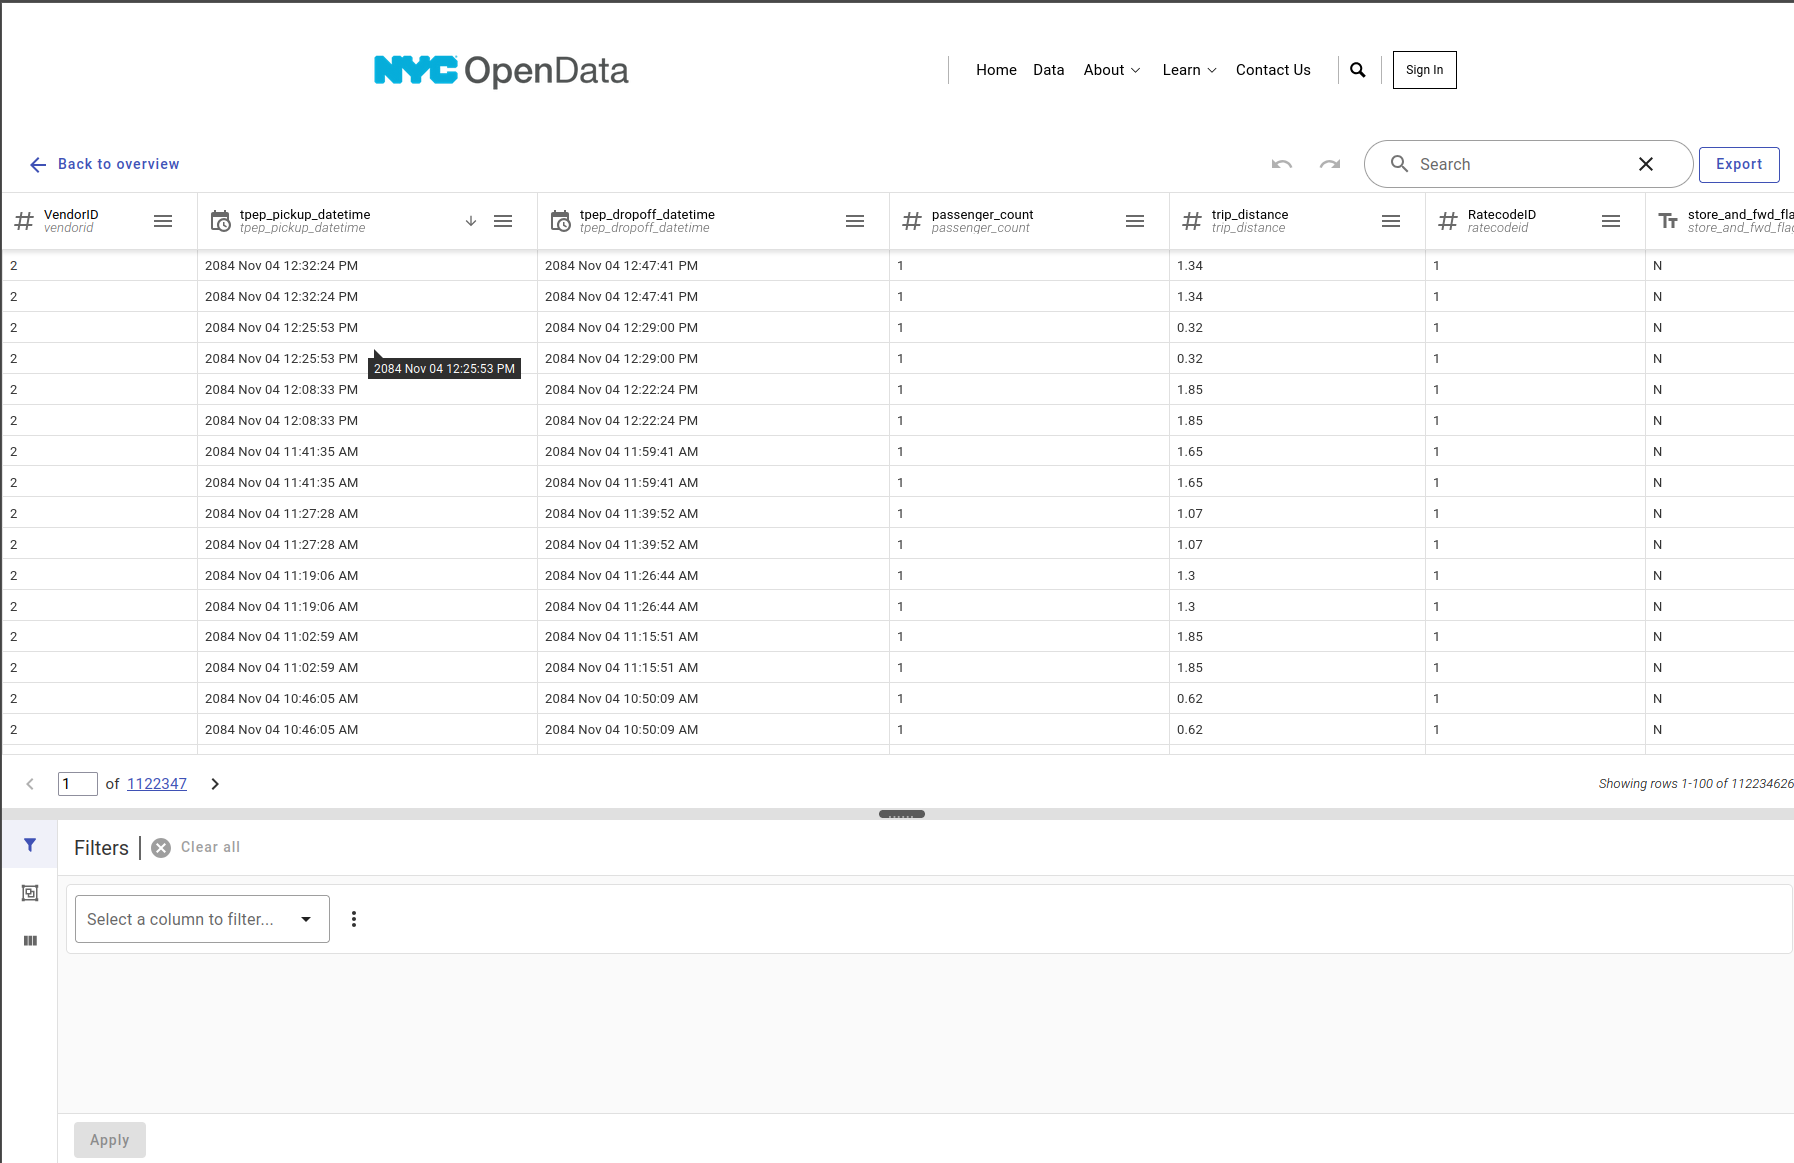

Apply a filter that only regards entries where the pick up time (tpep_pickup_datetime) is between 2018 Jan 01 12:00:00 AM and 2018 Dec 31 11:59:59 PM.

For the problems subject to our project you only need to download the following columns: tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance, PULocationID, DOLocationID. Other coloumns can be discarded, in order to speed up the download and save memory:

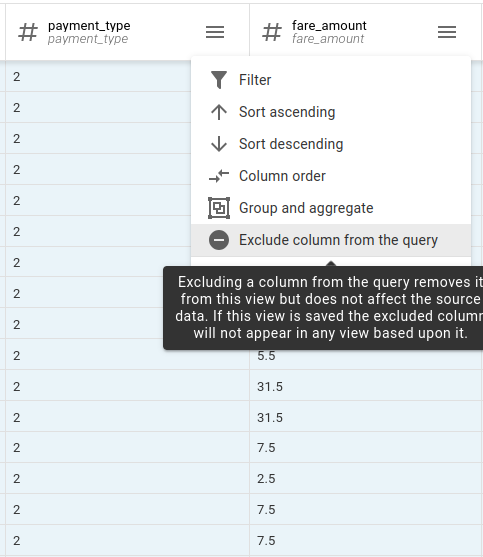

Please download the file (Export + Download file + CSV + download) and save it in the data folder as "Yellow_Taxi_Trip_Data.csv". It should be around 8 GB.

Moreover, we already provide the downloaded taxi zone lookup shape file in "data/Taxi_Zones/", since we needed to adjust some details. 

# 2. Set-up

After downloading, please execute the following cells. If you haven't installed the following libraries, then please make sure to do that (e.g. via pip install):

In [6]:
import pandas as pd                         # data handling
import numpy as np                          # numerical computations
import networkx as nx                       # graph handling
import matplotlib.pyplot as plt             # plotting
import geopandas as gpd                     # geospatial data handling
from Graph_class import Graph               # Graph_class defines our graph
import datetime as dt                       # Use for time formats
from Graph_building import *                # Imports functions that make it easier to create graphs
import pickle                               # Allows to efficiently save results
from IPython.display import display, Latex  # For Displaying

In [7]:
# Load the data set into a pandas dataframe and parse the times as timestamps
file_path = "../data/Yellow_Taxi_Trip_Data.csv"
df = pd.read_csv(file_path, parse_dates=["tpep_pickup_datetime", "tpep_dropoff_datetime"])

/tmp/ipykernel_326088/2973953791.py:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, parse_dates=["tpep_pickup_datetime", "tpep_dropoff_datetime"])


In [8]:
# Sort the entries by pickup time
# If the data frame is already sorted, no need to sort it again
if df['tpep_pickup_datetime'].is_monotonic_increasing:
    print("The dataframe is already sorted!")
else:
    print("The dataframe is not yet sorted. Sorting will take some time (around 7 minutes for the full dataset)")
    df = df.sort_values("tpep_pickup_datetime", ascending=True)
    print("Sorted!!!")
    display(df)

The dataframe is already sorted!


In [10]:
name_lookup=pd.read_csv("../data/taxi_zone_lookup.csv")
name_lookup.set_index("LocationID",inplace=True)
# Load TLC Taxi Zones shapefile (download and unzip first)
zones = gpd.read_file("../data/Taxi_Zones/geo_data_fixed.shp")

# Extract LocationID and centroid coordinates
zones['x'] = zones.geometry.centroid.x
zones['y'] = zones.geometry.centroid.y

zones["lon"] = zones.geometry.centroid.x
zones["lat"] = zones.geometry.centroid.y

# Map LocationID -> index (0..n-1)
# location_ids = sorted(zones["locationid"])
location_ids = np.arange(1,264, dtype = float)

/tmp/ipykernel_326088/1537805631.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zones['x'] = zones.geometry.centroid.x
/tmp/ipykernel_326088/1537805631.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zones['y'] = zones.geometry.centroid.y
/tmp/ipykernel_326088/1537805631.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zones["lon"] = zones.geometry.centroid.x
/tmp/ipykernel_326088/1537805631.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS b

In [11]:
id_to_idx = {loc: i for i, loc in enumerate(location_ids)}
idx_to_id = {i: loc for loc,i in id_to_idx.items()}

# Positions as required by networkx (node index -> (x,y))
positions = { id_to_idx[int(row.locationid)]: (row.lon, row.lat)
              for _, row in zones.iterrows() }

# 3 Basics

In the following you can see how to define graph signals and plot them:

In [ ]:
start_end_months = (1,12)               # Start and end months are included in the tuple
weekdays = [i for i in range(1,8)]      # For weekdays we use 1 to 7
t_begin = dt.time(0,0,0,0)
duration = dt.time(23,59,59,99)

passenger_matrix_sym,node_values1=build_adjacency_matrix(df,start_end_months,weekdays,t_begin,duration,mat_selecter=2)

In [40]:
G = Graph(passenger_matrix_sym**2,positions=positions,zone_lookup_df=name_lookup)

In [ ]:
# Plot the node_values1 signal:
G.plot(node_values=node_values1, save_plot=False, plot_name="AverageSignal")

In [ ]:
# Plot eigenvectors
method = "normalized_laplacian" # Feel free to assign method "adjacency", "laplacian" or "normalized_laplacian"
eigvals, eigvecs = G.spectrum(matrix_type=method)
# Choose eigenvalues you want to plot
choice = (0,1,2,3,10,50,200)
for i, c in enumerate(choice):
    print(f"Eigenvalue: {eigvals[c]}")
    G.plot(node_values=eigvecs.T[c])

In [ ]:
# Plot the spectral energy of a signal
G.plot_spectral_energy(signal=node_values1,matrix_type="normalized_laplacian",lf_components=20)

# 4 Anomaly Detection (GFT)

In order to detect anomalies, we created signals that covered 6 hours of the Data Set and compared their spectral energies. In order to get meaningful results, we categorized the signals as described in the report. For the comparison to be possible, we needed to create one graph per category:

In [ ]:
graph_list_improved = []
duration = dt.time(hour=5,minute=59, second=59,microsecond=999999)
for i in range(4):
    # Iterate over all seasons
    start_end_months = [[1,3],[4,6],[7,9],[10,12]][i]
    for day in range(7):
        # For weekdays and weekends seperately
        for hou in range(5,24,6):
            # iterate over all quarter days
            adjacency,normal_signal = build_adjacency_matrix(df,start_end_months,np.array([day]),t_begin,duration,mat_selecter=2)
            graph_list_improved.append(Graph(np.pow(adjacency,2),positions=positions, zone_lookup_df=name_lookup))
    print(f"Season {i} done!")

In [ ]:
def anomaly_dict_quarter_days_improved(df,Graphs):
    """
    Improved anomaly dictonary
    
    """
    anomaly_list = np.zeros(shape=(365*4))
    
    duration = dt.timedelta(hours=5,minutes=59,seconds=59,milliseconds=999,microseconds=999)
    for i in range(365*4):
        start_date = i*dt.timedelta(hours=6) + dt.datetime(2017,12,31,23)
        end_date = start_date + duration
        specific_values = get_specific_data(df,start_date, end_date,mat_selecter=2).sum(axis=1)
        # Choosing the correct graph is non-trivial now. We need to know: season, weekday/weekend and time
        season = 0
        if start_date.month in (1,2,3):
            season = 0
        elif start_date.month in (4,5,6):
            season = 1
        elif start_date.month in (7,8,9):
            season = 2
        else:
            season = 3

        time = start_date.hour // 6

        weekday=start_date.weekday()
        #print(f"time: {time},     weekday:{weekday},     season:{season}")

        x_hat= Graphs[28*season + weekday*4 + time].fast_gft(specific_values)
        spectral_energy_concentration = (np.linalg.norm(x_hat[0:20])**2) / (np.linalg.norm(x_hat)**2)
        anomaly_list[i] = spectral_energy_concentration
        if i % 30 == 0:
            print(f"{i/(365*4):.2%}")
    return anomaly_list

In [ ]:
anomaly_dict_3_improved = anomaly_dict_quarter_days_improved(df,graph_list_improved)

In [ ]:
# The results
anomaly_dict_3_dt = np.array([dt.datetime(2017,12,31,23,0,0) for i in range(365*4)]) + np.array(anomaly_dict_3_improved.argsort()) * dt.timedelta(hours=6)
anomaly_dict_3_dt[:30]

In [ ]:
# Plot a histogram
plt.hist(anomaly_dict_3_improved, bins=100)

In [ ]:
# Plot some of the anomalies

for i, date in enumerate(anomaly_dict_3_dt[:10]):
    
    weekday = date.weekday()
    quarter_number = date.hour // 6


    season = 0
    if date.month in (3,4,5):
        season = 0
    elif date.month in (6,7,8):
        season = 1
    elif date.month in (9,10,11):
        season = 2
    else:
        season = 3

    time = ((date.hour+1)%24) // 6

    weekday=date.weekday()
    #print(f"time: {time},     weekday:{weekday},     season:{season}")

    signal = get_specific_data(df,date,date+datetime.timedelta(hours=6),mat_selecter=2).sum(axis=1)
    print(date)
    # graph_list[weekday*4 + quarter_number].plot_spectral_energy(signal)
    # graph_list_improved[28*season + weekday*4 + time].plot_wavelet_spectrum(node_values=signal,ns=5)
    graph_list_improved[28*season + weekday*4 + time].plot(signal)

# 5 Anomaly detection using the wavelet transform

In order to find the anomalies locally, the wavelet transform can be used:

In [43]:
# Pickups at a specific day and hour where we expect anormal behavior (e.g. Christmas Eve 2018 6 PM)
t_begin = "2018-01-01 02:00:00"
t_end = "2018-01-01 04:00:00"
specific_data = get_specific_data(df,t_begin, t_end,mat_selecter=2)
specific_values = specific_data.sum(axis=1)

In [ ]:
G.plot_wavelet_spectrum(node_values=specific_values,ns = 7, colormap="plasma", matrix_type="normalized_laplacian")

Please refer to the report in order to find anomalies. The wavelet transform is sampled here (since it is a continuous transform), the small frequencies are shown in the beginning and the high frequencies at the end.

# 6 Scattering Transform

In the following, we define all functions needed for calculating the scattering transform:

In [45]:
def lowpass(signal,eigvals,eigvecs):
    h = np.array([1 if n < 50 else 0 for n in range(len(eigvals))])
    x_hat_filtered = h * (eigvecs.T @ signal)
    x_filtered = eigvecs @ x_hat_filtered
    return x_filtered

We created to versions of the scattering transform:

In [ ]:
# ScatteringTransformList is less efficient since it uses lists instead of numpy arrays, but it 
# makes it easier to find coefficients of the scattering transform.
def scatteringTransformList(signal,G,l,ns,matrix_type):
    """_summary_

    Args:
        signal (np.array): Signal to be transformed
        G (Graph): underlying Graph
        l (int): number of layers
        ns (int): number of wavelet scaling sample points
    Return:
        nested list holding the coefficients of the wavelet tranform
    """
    if l < 1:
        raise ValueError("Choose at least one layer")
    
    transform = []
    
    #gft used for GWT and to set limits for s
    ft,vals,vecs=G.gft(node_values1,matrix_type)
    #set according to "Wavelets on Grophs via Spectral Graph Theory" page 26
    t1=2/vals[1]
    tend=2/vals[-1]
    s = np.linspace(t1,tend,ns)
    
    # The first coefficient is just the low-pass filtered signal
    transform.append([lowpass(signal,vals,vecs)])
    
    
    # Iterate over all layers
    for layer in range(1,l):
        # Apply the gwt to all signals of the level before and put the coefficients in a list
        level_list = []
        for x in transform[layer-1]:
            level_list += (list(G.gwt(x,s,matrix_type).T))  # Transpose so that each entry of the level list is a vector
            # non-linearity and low-pass filtering
            for i, v in enumerate(level_list):
                level_list[i] = (v.clip(min=0))
        transform.append(level_list)
    return transform
    
    

In [47]:
def scatteringTransform(signal,G,l,ns,matrix_type):
    """_summary_

    Args:
        signal (np.array): Signal to be transformed
        G (Graph): underlying Graph
        l (int): number of layers
        ns (int): number of wavelet scaling sample points
    Return:
        vector holding the coefficients of the wavelet tranform
    """
    if l < 1:
        raise ValueError("Choose at least one layer")
    
    transform = np.zeros(shape=(sum([pow(ns,i) for i in range(l)]) * 263))
    
    #gft used for GWT and to set limits for s
    ft,vals,vecs=G.gft(node_values1,matrix_type)
    #set according to "Wavelets on Grophs via Spectral Graph Theory" page 26
    t1=2/vals[1]
    tend=2/vals[-1]
    s = np.linspace(t1,tend,ns)
    
    # The first coefficient is just the low-pass filtered signal
    transform[0:263] = lowpass(signal,vals,vecs)
    
    
    # Iterate over all layers
    for layer in range(1,l):
        # Apply the gwt to all signals of the level before and put the coefficients in a list
        prev_layer = layer - 1
        layer_offset = (sum([pow(ns,i) for i in range(layer)]) * 263)
        layer_offset_prev = (sum([pow(ns,i) for i in range(prev_layer)]) * 263)
        
        for n in range(pow(ns,prev_layer)):
            x= transform[layer_offset_prev+n*263:layer_offset_prev+(n+1)*263]
            transform[layer_offset + 263*ns*n:layer_offset + 263 * ns *(n+1)] = (G.gwt(x,s,matrix_type).T).flatten()  # Transpose so that each entry of the level list is a vector
            
            # non-linearity and low-pass filtering
            for j in range(ns):
                # Modulus?
                # weglassen der non-linearity?
                transform[layer_offset + 263 * j:layer_offset + 263 * (j+1)] = lowpass(np.clip(transform[layer_offset + 263 * j:layer_offset+ 263 *(j+1)],min=0.2),vals,vecs)
    return transform

In [ ]:
testScatteringTransform = scatteringTransform(node_values1,G,4,4,"normalized_laplacian")

### Day-Night-Experiment
A support vector machine is fed with the scattering transform of our signals and needs to classify if a signal corresponds to day or night.

In [48]:
# 1 -> day
# 0 -> night
labels1 = np.array([1 if i%2==0 else 0 for i in range(0, 365*2)])

In [49]:
l = 3
ns = 8

# Size of the scattering transform (263 * number of coefficients)
scattering_size = sum([pow(ns,i) for i in range(l)]) * 263
print(f"Scattering size: {scattering_size}")


Scattering size: 19199


In [ ]:
t_begin = dt.datetime(2018, 1, 1, 8,00,00)

data1 = np.zeros((365*2,263))
data_transformed1 = np.zeros(shape=(365*2,scattering_size))


t_delta = dt.timedelta(hours=12)
for i in range(365*2):
    curr=get_specific_data(df,t_begin,t_begin+t_delta,mat_selecter=2).sum(axis=1)
    data1[i,:] = curr
    data_transformed1[i,:] = scatteringTransform(curr,G,l,ns,"normalized_laplacian")
    t_begin += t_delta
    if i % 20 == 0:
        print(i)

In [52]:
# Split data into test data and validation data (80/20)
train_data1 = np.zeros(shape=(584,scattering_size))
validation_data1 = np.zeros(shape=(146,scattering_size))
train_labels1 = np.zeros(584)
validation_labels1 = np.zeros(146)

for i in range(146):
    # print(i)
    train_data1[i*4:(i+1)*4]=data_transformed1[i*5:(i+1)*5 - 1,:]
    validation_data1[i] = data_transformed1[5*(i+1)-1,:]
    
    train_labels1[i*4:(i+1)*4]=labels1[i*5:(i+1)*5 - 1]
    validation_labels1[i] = labels1[5*(i+1)-1]

Here we train the model:

In [ ]:
model1 = sklearn.pipeline.Pipeline([
    ("scaler", sklearn.preprocessing.StandardScaler()),
    ("svc", sklearn.svm.SVC(kernel='linear'))
])

model1.fit(train_data1, train_labels1)

In [ ]:
validation_counter1 = 0
for i in range(146):
    prediction = model1.predict([validation_data1[i]])
    if validation_labels1[i] == prediction:
        validation_counter1 += 1
        # print(prediction)
        
    else:
        print(i)

In [ ]:
# Show misclassifications of our model:
outlier_counter = 0
for i in range(365*2):
    if labels1[i] == model1.predict([data_transformed1[i,:]]):
        pass
    else:
        outlier_counter += 1
        a = dt.timedelta(hours=12) * i + dt.datetime(2018,1,1,8,0,0)
        print(f"Day: {a.weekday(), } {a}; Prediction: {model1.predict([data_transformed1[i,:]])}, Truth: {labels1[i]}")
print(f"Outlier Count: {outlier_counter}")

### Weekend/Weekday
Now, the SVM is trained to separate weekends from weekdays.

In [53]:
labels = np.array([1 if n%7==5 or n%7==6 else 0 for n in range(1,366)])

In [ ]:
l = 3
ns = 8

# Size of the scattering transform (263 * number of coefficients)
scattering_size = sum([pow(ns,i) for i in range(l)]) * 263
# print(f"Scattering size: {scattering_size}")

t_begin = dt.datetime(2018, 1, 1, 00,00,00)

data = np.zeros((365,263))
data_transformed = np.zeros(shape=(365,scattering_size))



for i in range(365):
    t_delta = dt.timedelta(days=1)
    curr=get_specific_data(df,t_begin,t_begin+t_delta,mat_selecter).sum(axis=1)
    data[i,:] = curr
    data_transformed[i,:] = scatteringTransform(curr,G,l,ns,"normalized_laplacian")
    t_begin += t_delta
    if i % 50 == 0:
        print(i)

In [ ]:
# Split data into test data and validation data
train_data = np.zeros(shape=(332,scattering_size))
validation_data = np.zeros(shape=(33,scattering_size))
train_labels = np.zeros(332)
validation_labels = np.zeros(33)

for i in range(365//11):
    # print(i)
    train_data[i*10:(i+1)*10]=data_transformed[i*11:(i+1)*11 - 1,:]
    validation_data[i] = data_transformed[11*(i+1)-1,:]
    
    train_labels[i*10:(i+1)*10]=labels[i*11:(i+1)*11 - 1]
    validation_labels[i] = labels[11*(i+1)-1]

In [ ]:
train_data_non_processed = np.zeros(shape=(332,263))
validation_data_non_processed = np.zeros(shape=(33,263))

for i in range(365 // 11):
    train_data_non_processed[i*10:(i+1)*10]=data[i*11:(i+1)*11 - 1,:]
    validation_data_non_processed[i] = data[11*(i+1)-1,:]

Again, we train:

In [ ]:
model = sklearn.pipeline.Pipeline([
    ("scaler", sklearn.preprocessing.StandardScaler()),
    ("svc", sklearn.svm.SVC(kernel='linear'))
])

model.fit(train_data, train_labels)

In [ ]:
validation_counter = 0
for i in range(33):
    if validation_labels[i] == model.predict([validation_data[i]]):
        validation_counter += 1
    else:
        print(i)

In [ ]:
outlier_counter = 0
for i in range(365):
    if labels[i] == model.predict([data_transformed[i,:]]):
        pass
    else:
        outlier_counter += 1
        a = dt.timedelta(days=1) * i + dt.datetime(2018,1,1,0,0,0)
        print(f"Day: {a.weekday()} {a}; Prediction: {model.predict([data_transformed[i,:]])}, Truth: {labels[i]}")

Now, we compare to non-preprocessed data:

In [ ]:
model_non_preprocessed = sklearn.pipeline.Pipeline([
    ("scaler", sklearn.preprocessing.StandardScaler()),
    ("svc", sklearn.svm.SVC(kernel='linear'))
])

model_non_preprocessed.fit(train_data_non_processed, train_labels)

In [ ]:
validation_counter1 = 0
for i in range(33):
    if validation_labels[i] == model_non_preprocessed.predict([validation_data_non_processed[i]]):
        validation_counter1 += 1
    else:
        print(i)

In [ ]:
outlier_counter = 0
for i in range(365):
    if labels[i] == model_non_preprocessed.predict([data[i,:]]):
        pass
    else:
        outlier_counter += 1
        a = dt.timedelta(days=1) * i + dt.datetime(2018,1,1,0,0,0)
        print(f"Day: {a.weekday()} {a}; Prediction: {model_non_preprocessed.predict([data[i,:]])}, Truth: {labels[i]}")